# Life Expectancy Prediction using Machine Learning

<b>Author:</b> Yung Qi Chin

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

In [2]:
lifespan = pd.read_csv('./train.csv') #inport train dataset

## Exploratory Data Analysis (EDA)

### Distribution of Data

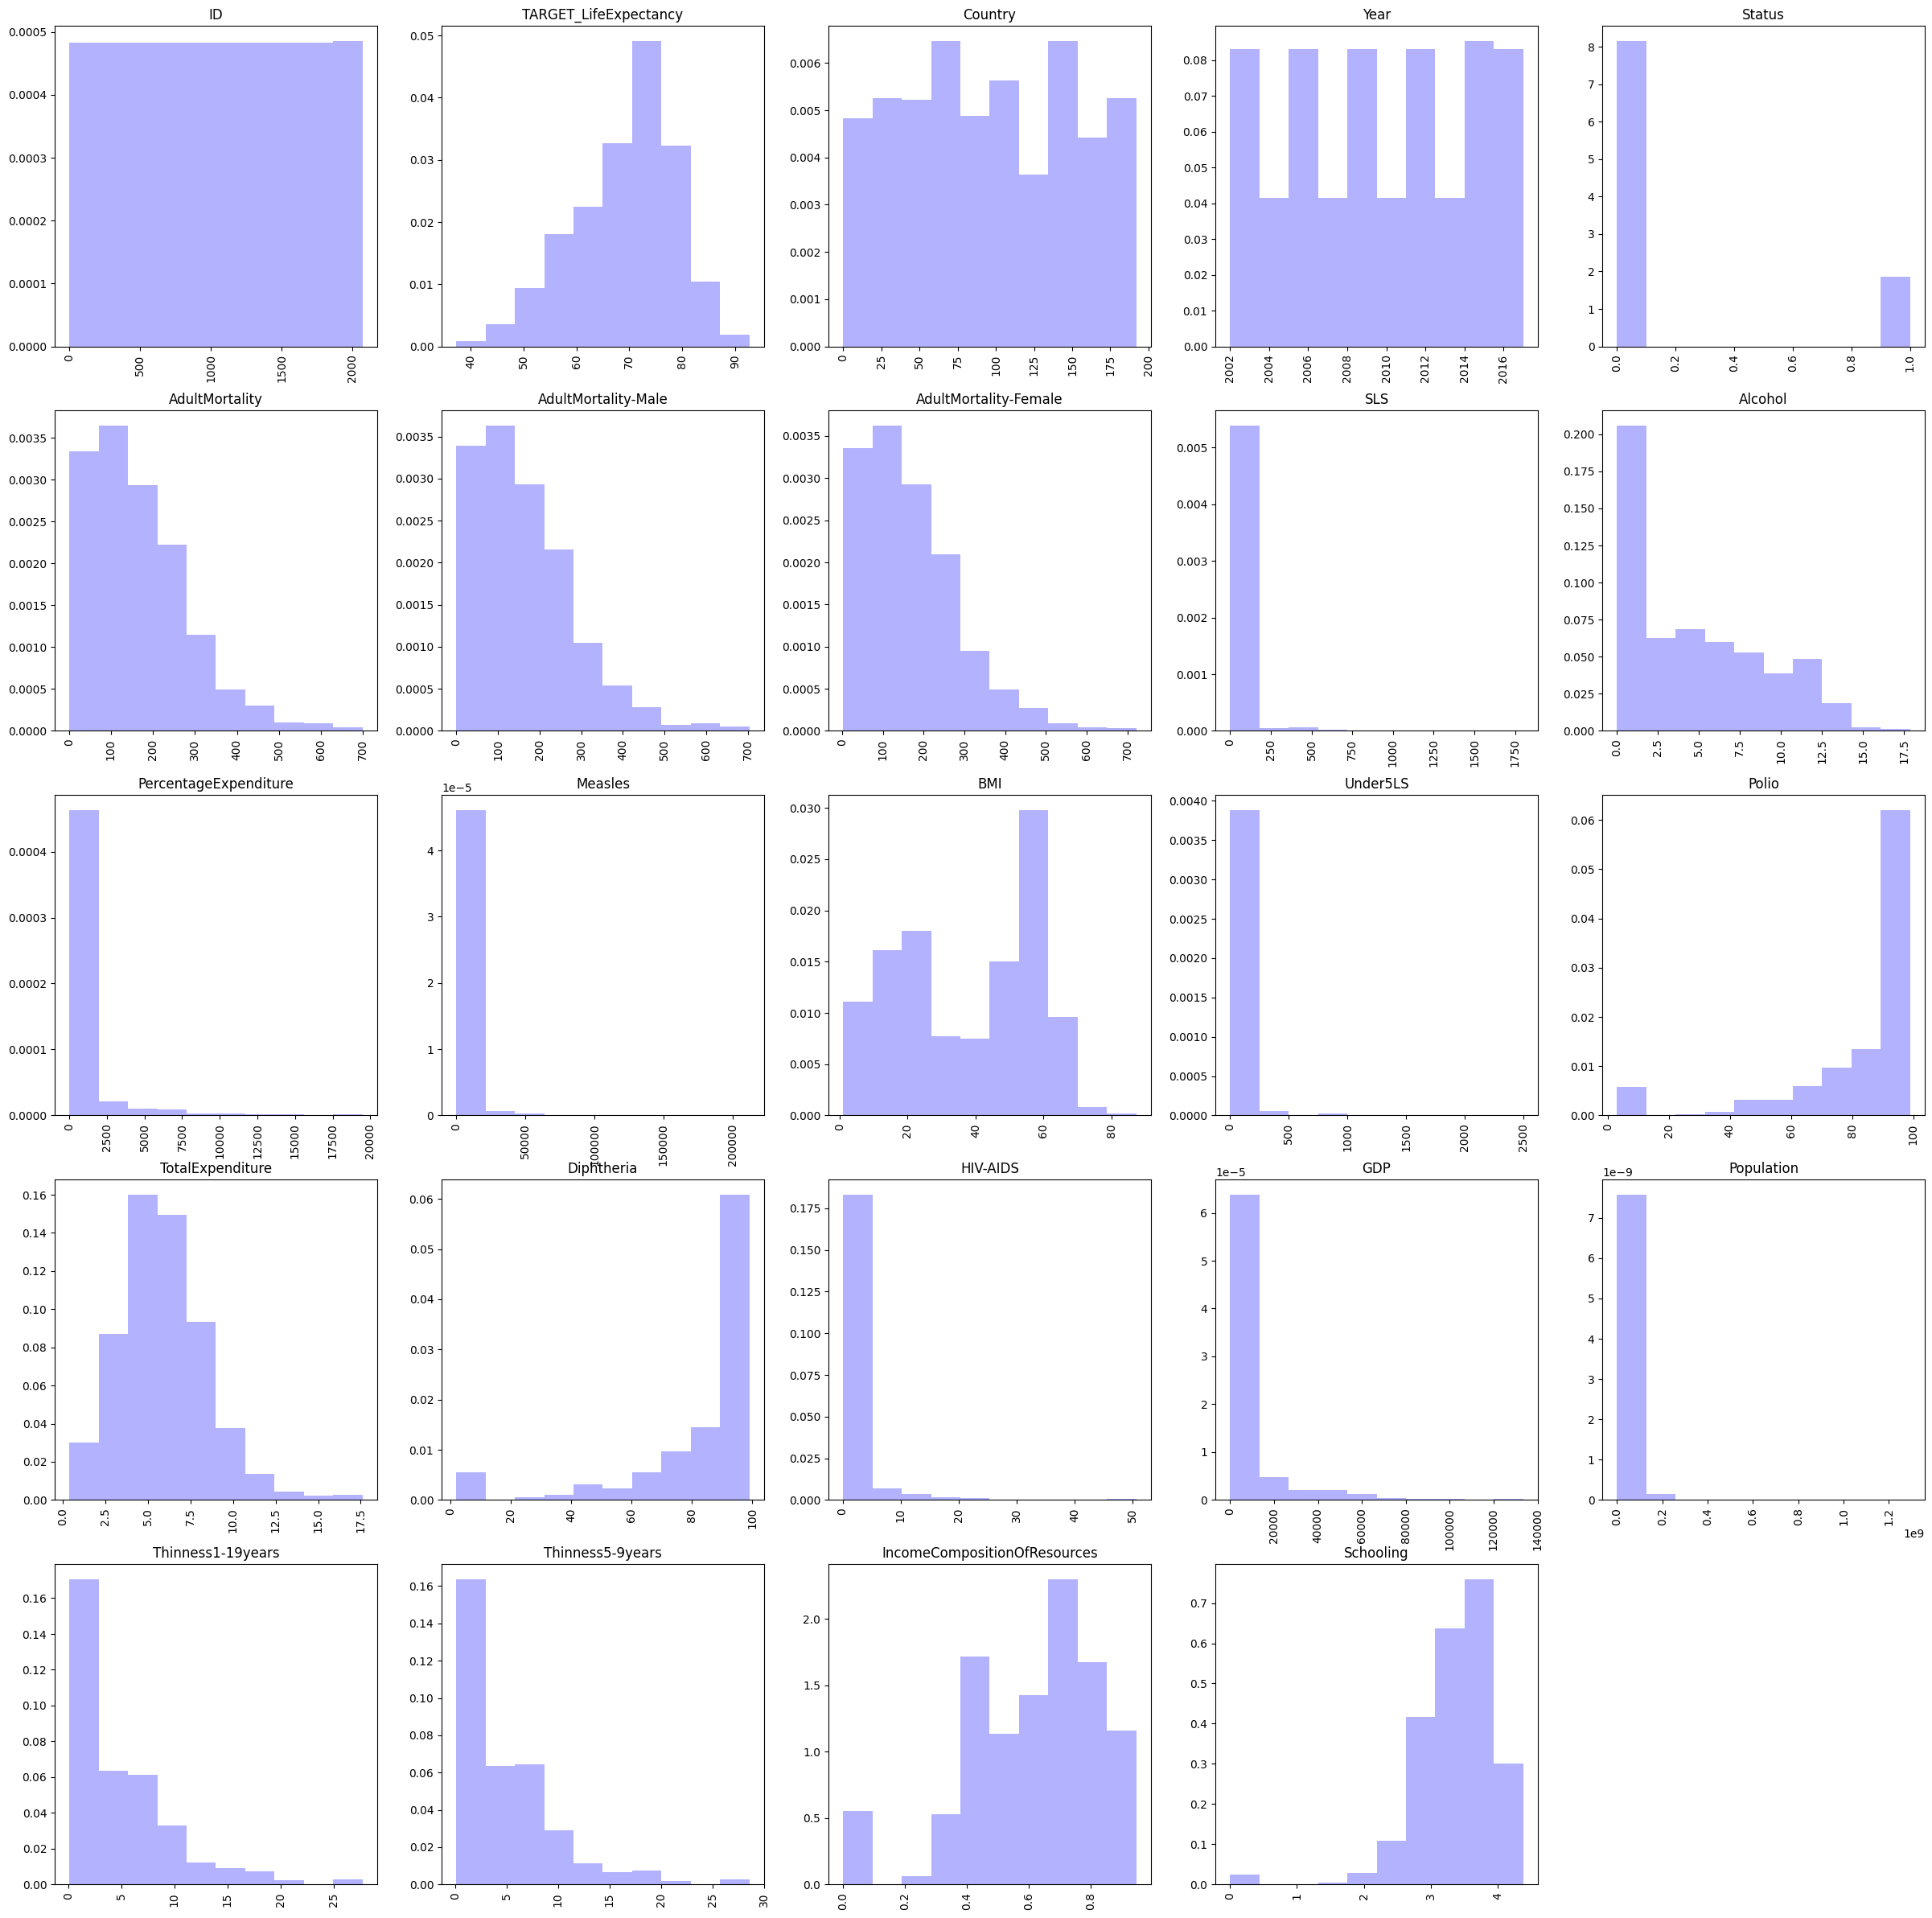

In [3]:
# Generate distribution chart for each attribute
plt.figure(figsize=(30,30))
for i, col in enumerate(lifespan.columns):
    plt.subplot(5,5,i+1)
    plt.hist(lifespan[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

* The attribute Status is a categorical variable, with most data instances falling into class 0, while only a few instances belong to class 1. It takes only value 0 and 1, so we do not need to transform it into dummy variable by performing one-hot encoding.
* We need to check if there is a need to perform normalisation in this dataset because some features like Adult Mortality, Adult Mortality-Male, Adult Mortality-Female, Polio, Diphtheria, Thinness1-19years and Thinness5-9years are highly skewed.
* We may need to remove outliers as there are some attributes such as SLS, Percentage Expenditure, Measles, Under5LS, HIV-AIDS, GDP, Population, Income Composition of Resources, and Schooling contain outliers, they might affect the performance of the model.


### Relationship between Target variable and Predictors

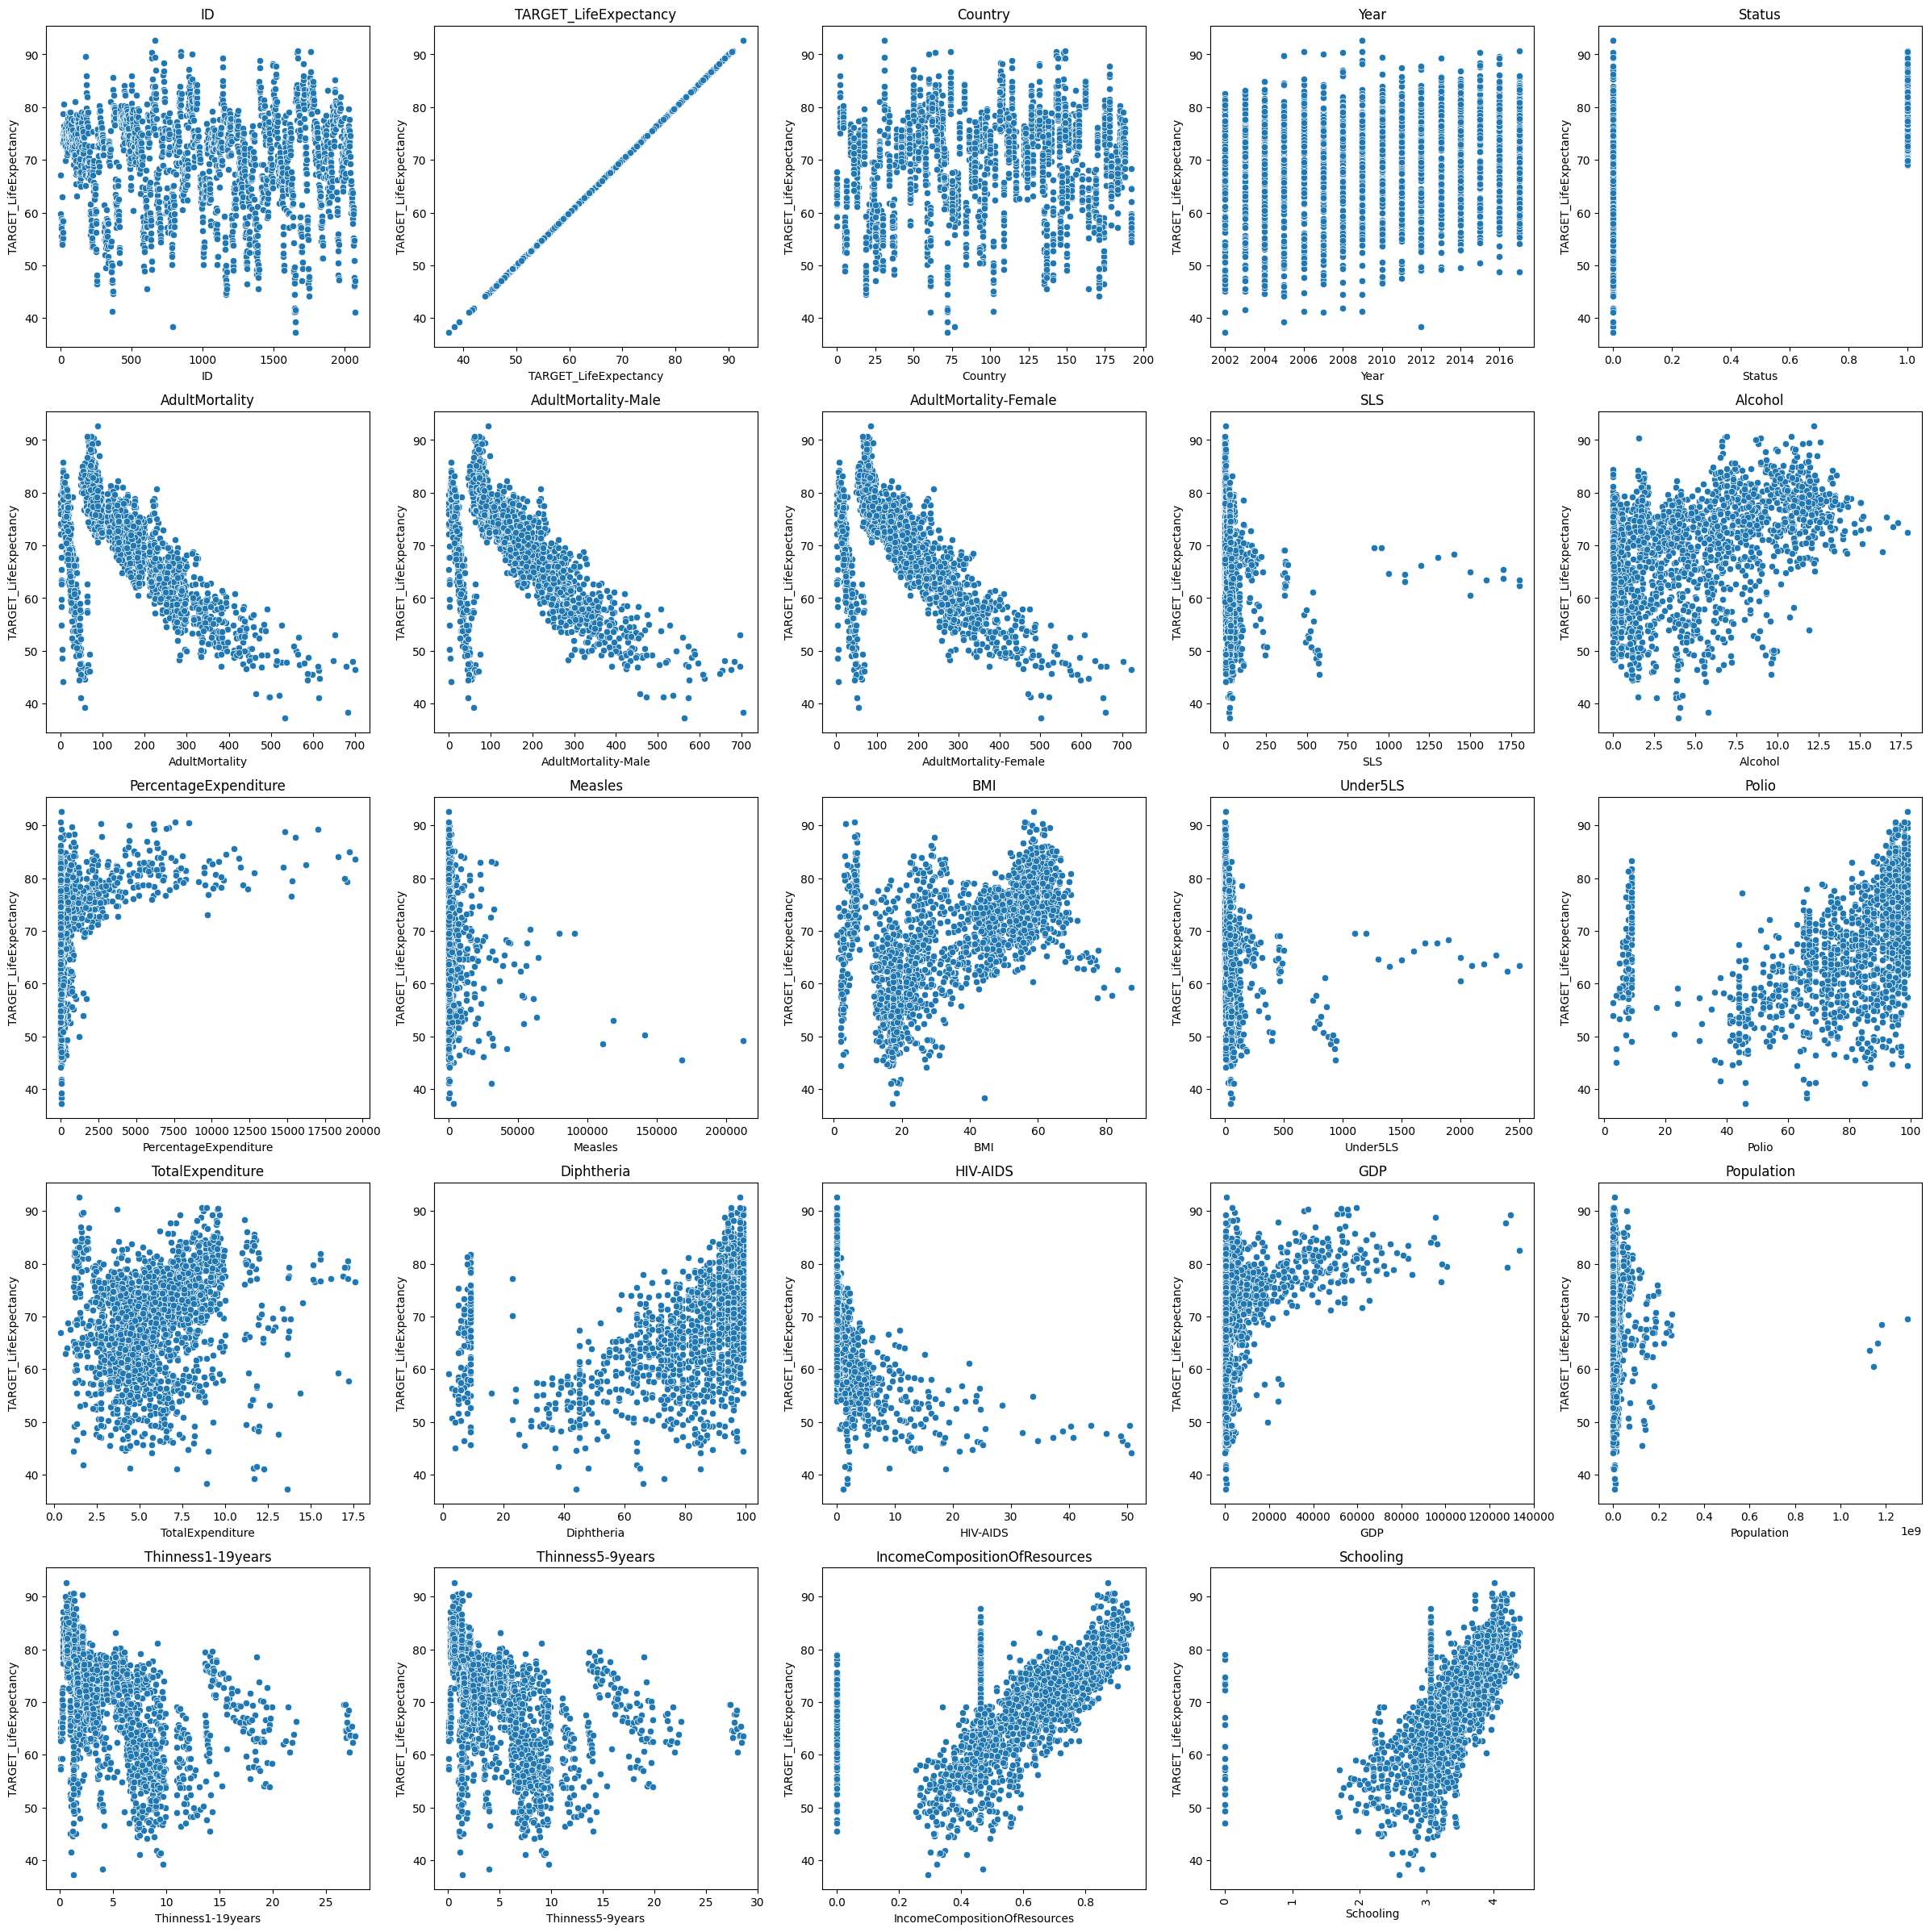

In [4]:
# Generate scatter plot for each attribute with target attribute
import seaborn as sns
plt.figure(figsize=(30,30))
for i, col in enumerate(lifespan.columns):
    plt.subplot(5,5,i+1)
    sns.scatterplot(data=lifespan, x=col, y='TARGET_LifeExpectancy')
    plt.title(col)

plt.xticks(rotation='vertical')
plt.show()

* A Linear Regression Model might be suitable because attributes Composition of Resources and Schooling have a positive linear relationship with the target Variable Life Expectancy, while attributes Adult Mortality, Adult Mortality-Male, and Adult Mortality-Female have a negative linear relationship with the target variable Life Expectancy.
* The relationship between Life Expectancy and some variables appears to be non-linear (e.g. Percentage Expenditure, HIV-AIDS, GDP).
* Some variables do not seem to have a relationship with the target variable. (e.g. Country, Measles, Under5LS, Total Expenditure, Population, Thinness1-19years, Thinness 5-9 years), removing them could potentially enhance the performance of the model.
* On average, the life expectancy for data instances with STATUS=1 is higher than for data instances with STATUS=0.


### Correlation Matrix

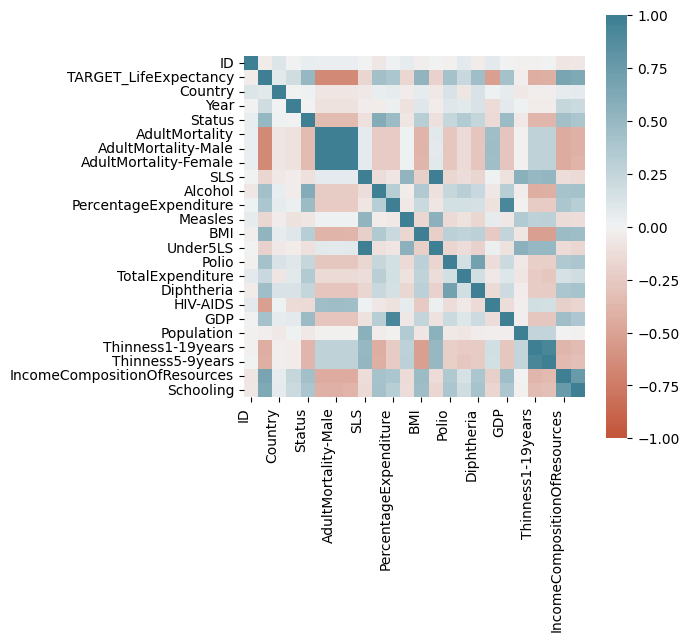

In [5]:
import seaborn as sns
# Generate Correlation Matrix
f, ax = plt.subplots(figsize=(5.5, 5.5))
corr = lifespan.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);


* Attributes Income Composition of Resources and Schooling have a strong correlation with the target attribute and Adult Mortality, Adult Mortality-Male, and Adult Mortality-Female have a strong negative correlation with the target attribute.
* There are many predictor variables are correlated to each other (e.g. Adult Mortality, Adult Mortality-Male, and Adult Mortality-Female).


## Random splitting

We split the data into a 60/20/20 ratio for training, testing, and validation, respectively. 

In [6]:
lifespan = lifespan.drop(['ID'], axis=1)

In [60]:
from sklearn.model_selection import train_test_split

# dataset splitting
with pd.option_context('mode.chained_assignment', None):
    train_data_, test_data = train_test_split(lifespan, test_size=0.2, 
                                              shuffle=True,random_state=0)

with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(train_data_, test_size=0.25, 
                                            shuffle=True,random_state=0)

In [61]:
# Split the dataset into independent and dependent set
train_X = train_data.drop(['TARGET_LifeExpectancy',], axis=1)
train_y = train_data[['TARGET_LifeExpectancy']]
test_X = test_data.drop(['TARGET_LifeExpectancy',], axis=1)
test_y = test_data[['TARGET_LifeExpectancy']]
val_X = val_data.drop(['TARGET_LifeExpectancy',], axis=1)
val_y = val_data[['TARGET_LifeExpectancy']]

## Baseline Model

* Basic linear regression were chosen as baseline model for this task. 
* Based on our EDA, we observed strong linear relationships between some variables in the data and the target variable.
* R2 score and Mean Squared Error will be used to evaluate the performance of our models.

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Fit a linear Regression
model_us_lr = LinearRegression().fit(train_X, train_y)
                                     
# Predict test data using the fitted model
test_us_pred = model_us_lr.predict(test_X)

# Evaluation Method
r2_us_lr_1 = r2_score(test_y, test_us_pred)
mse_us_lr_1 = mean_squared_error(test_y, test_us_pred)

print("R^2 Score for Unscaled Linear Regression:", r2_us_lr_1)
print("Mean Squared Error for Unscaled Linear Regression:", mse_us_lr_1)

R^2 Score for Unscaled Linear Regression: 0.7532789321708078
Mean Squared Error for Unscaled Linear Regression: 20.974711754181115


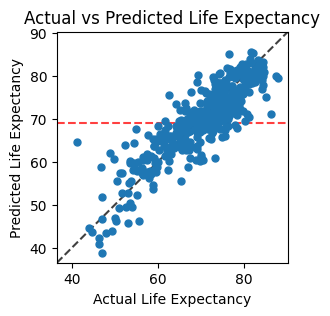

In [63]:
# Fit Actual vs Predicted data
fig, ax = plt.subplots()
ax.scatter(test_y, test_us_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(train_y),]*2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.rcParams['figure.figsize'] = [3, 3]
plt.title("Actual vs Predicted Life Expectancy")
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')

plt.show()

* From the Predicted vs Actual Life Expectancy graph for our baseline model, we can see that the data points closely align with the linear line. 
* This suggests that the model performs significantly better than using the mean. 

In [64]:
print("The mean value of residuals: " + str(np.mean(test_y-test_us_pred)))

The mean value of residuals: 0.36377223862406444


The residuals have a mean value close to 0.

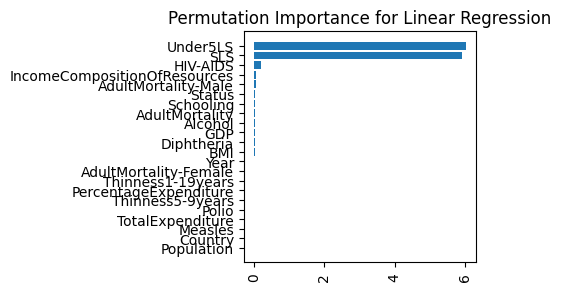

In [65]:
from sklearn.inspection import permutation_importance

# Permutation Importance
r = permutation_importance(model_us_lr, test_X, test_y, n_repeats=30)
inx = np.argsort(r.importances_mean)

plt.barh(test_X.columns[inx], r.importances_mean[inx])
plt.xticks(rotation='vertical')
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.title("Permutation Importance for Linear Regression")
plt.show()

* Top Three most important variables for predicting Life Expectancy: SLS, Under5LS
* Top Three least important variables for predicting Life Expectancy: Population, Country and Polio
* The top three most important variables identified in the coefficient importance graph do not align with the analysis conducted during EDA because they do not have linear relationships with the target variable. 
* SLS and Under5LS are strongly correlated to each other, suggesting the presence of multicollinearity.

## Polynomial Regression

* We will fit a polynomial regression model because as discussed in the EDA, some features exhibit a non-linear relationship with the target variable.  

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(2) # Define the polynomial Degree
X_poly = poly.fit_transform(train_X) # Transform our predictors to polynomial
model_poly_us = LinearRegression().fit(X_poly, train_y)
X_test_poly = poly.fit_transform(test_X) # Transform our predictors to polynomial
test_poly_us_pred = model_poly_us.predict(X_test_poly) # Predict test set using the fitted model

# Evaluation Method
r2_poly_us = r2_score(test_y, test_poly_us_pred)
mse_poly_us = mean_squared_error(test_y, test_poly_us_pred)
print("R^2 Score for Polynomial Regression:", r2_poly_us)
print("Mean Squared Error for Polynomial Regression:", mse_poly_us)

R^2 Score for Polynomial Regression: 0.7118842384660922
Mean Squared Error for Polynomial Regression: 24.493834690249628


* The polynomial regression model performs slightly worse than our baseline model. 
* It's worth considering fitting the polynomial regression again after feature scaling and normalization.

## Feature Removal (Unimportant Variables) 

 *  Based on the baseline model, we might need to observe the performance of the model after removing Population, TotalExpenditure, Thinness5-9years, Polio and Country attributes because they do not contribute much to the target variable.
* We will see the effects and observe how the performance of the model changes with the removal of each attribute.

In [66]:
# Drop feature in all the three datasets
train_X = train_X.drop(['Thinness5-9years',], axis=1)
test_X = test_X.drop(['Thinness5-9years',], axis=1)
val_X = val_X.drop(['Thinness5-9years',], axis=1)

# Model fitting
model_us_lr = LinearRegression().fit(train_X, train_y)
test_us_pred = model_us_lr.predict(test_X)

# Evaluation Method
r2_us_lr = r2_score(test_y, test_us_pred)
mse_us_lr = mean_squared_error(test_y, test_us_pred)

print("R^2 Score for Unscaled Linear Regression after dropping Thinness5-9years:", r2_us_lr)
print("Mean Squared Error for Unscaled Linear Regression after dropping Thinness5-9years:", mse_us_lr)

R^2 Score for Unscaled Linear Regression after dropping Thinness5-9years: 0.7508166422622521
Mean Squared Error for Unscaled Linear Regression after dropping Thinness5-9years: 21.184040538064863


In [67]:
# Drop feature in all the three datasets
train_X = train_X.drop(['Population',], axis=1)
test_X = test_X.drop(['Population',], axis=1)
val_X = val_X.drop(['Population',], axis=1)

# Model fitting
model_us_lr = LinearRegression().fit(train_X, train_y)
test_us_pred = model_us_lr.predict(test_X)

# Evaluation Method
r2_us_lr = r2_score(test_y, test_us_pred)
mse_us_lr = mean_squared_error(test_y, test_us_pred)

print("R^2 Score for Unscaled Linear Regression after dropping Population:", r2_us_lr)
print("Mean Squared Error for Unscaled Linear Regression after dropping Population:", mse_us_lr)

R^2 Score for Unscaled Linear Regression after dropping Population: 0.7521000987749294
Mean Squared Error for Unscaled Linear Regression after dropping Population: 21.07492893831663


In [68]:
# Drop feature in all the three datasets
train_X = train_X.drop(['TotalExpenditure',], axis=1)
test_X = test_X.drop(['TotalExpenditure',], axis=1)
val_X = val_X.drop(['TotalExpenditure',], axis=1)

# Model fitting
model_us_lr = LinearRegression().fit(train_X, train_y)
test_us_pred = model_us_lr.predict(test_X)

# Evaluation Method
r2_us_lr = r2_score(test_y, test_us_pred)
mse_us_lr = mean_squared_error(test_y, test_us_pred)

print("R^2 Score for Unscaled Linear Regression after dropping TotalExpenditure:", r2_us_lr)
print("Mean Squared Error for Unscaled Linear Regression after dropping TotalExpenditure:", mse_us_lr)

R^2 Score for Unscaled Linear Regression after dropping TotalExpenditure: 0.7521678331639212
Mean Squared Error for Unscaled Linear Regression after dropping TotalExpenditure: 21.06917057605982


In [69]:
# Drop feature in all the three datasets
train_X = train_X.drop(['Country',], axis=1)
test_X = test_X.drop(['Country',], axis=1)
val_X = val_X.drop(['Country',], axis=1)

# Model fitting
model_us_lr = LinearRegression().fit(train_X, train_y)
test_us_pred = model_us_lr.predict(test_X)

# Evaluation Method
r2_us_lr = r2_score(test_y, test_us_pred)
mse_us_lr = mean_squared_error(test_y, test_us_pred)

print("R^2 Score for Unscaled Linear Regression after dropping Country:", r2_us_lr)
print("Mean Squared Error for Unscaled Linear Regression after dropping Country:", mse_us_lr)

R^2 Score for Unscaled Linear Regression after dropping Country: 0.7525106454650219
Mean Squared Error for Unscaled Linear Regression after dropping Country: 21.0400267770943


In [70]:
# Drop feature in all the three datasets
train_X = train_X.drop(['Polio',], axis=1)
test_X = test_X.drop(['Polio',], axis=1)
val_X = val_X.drop(['Polio',], axis=1)

# Model fitting
model_us_lr = LinearRegression().fit(train_X, train_y)
test_us_pred = model_us_lr.predict(test_X)

# Evaluation Method
r2_us_lr = r2_score(test_y, test_us_pred)
mse_us_lr = mean_squared_error(test_y, test_us_pred)

print("R^2 Score for Unscaled Linear Regression before dropping all unimportant variables:", r2_us_lr_1)
print("Mean Squared Error for Unscaled Linear Regression before dropping all unimportant variables:", mse_us_lr_1)
print("R^2 Score for Unscaled Linear Regression after dropping all unimportant variables:", r2_us_lr)
print("Mean Squared Error for Unscaled Linear Regression after dropping all unimportant variables:", mse_us_lr)

R^2 Score for Unscaled Linear Regression before dropping all unimportant variables: 0.7508672856073231
Mean Squared Error for Unscaled Linear Regression before dropping all unimportant variables: 21.17973515152257
R^2 Score for Unscaled Linear Regression after dropping all unimportant variables: 0.7532789321708078
Mean Squared Error for Unscaled Linear Regression after dropping all unimportant variables: 20.974711754181115


* There isn't much difference in both our R^2 Score and Mean Square Error after dropping unimportant variables.

## Feature Scaling and Normalisation

* From the EDA, we noticed that none of the top three important variables exhibit strong linear relationships with the target variable. 
* Their coefficients are relatively higher compared to those variables with strong linear relationships. 
* It is worth considering applying feature scaling or normalization on the data to reduce the impact of outliers and ensure that the data is on the same scale. We will first apply scaling on all predictors and examine the model’s performance.

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

train_X_scaled = train_X.copy()
test_X_scaled = test_X.copy()
val_X_scaled = val_X.copy()

# Use MinMaxScaler() to perform Feature Scaling, making them all in the same scale
minmaxscaler = MinMaxScaler().fit(train_X_scaled)
train_X_scaled = minmaxscaler.transform(train_X_scaled)
test_X_scaled = minmaxscaler.transform(test_X_scaled)
val_X_scaled = minmaxscaler.transform(val_X_scaled)

In [19]:
# Model Fitting
model_lr = LinearRegression().fit(train_X_scaled, train_y)
test_lr_pred = model_lr.predict(test_X_scaled)

# Evaluation method
r2_lr = r2_score(test_y, test_lr_pred)
mse_lr = mean_squared_error(test_y, test_lr_pred)
print("R^2 Score for Scaled Linear Regression:", r2_lr)
print("Mean Squared Error for Scaled Linear Regression:", mse_lr)

R^2 Score for Scaled Linear Regression: 0.7525106454650666
Mean Squared Error for Scaled Linear Regression: 21.040026777090496


* It appears that there isn't a significant difference in the R2 and Mean Squared Error after applying feature scaling. 
* Apply both feature scaling and normalization to attributes that were identified as highly skewed during the EDA (e.g., Schooling, Adult Mortality, Adult Mortality-Male, Adult Mortality-Female, Polio, Diphtheria, Thinness1-19years), and then evaluate the model's performance.

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# logNorm_attributes are list of attributes that are considered highly skewed that were defined during EDA
logNorm_attributes = ['Schooling','AdultMortality','AdultMortality-Male','AdultMortality-Female','Diphtheria','Thinness1-19years']
# All other attributes
minmax_attributes = list(set(train_X.columns).difference(set(logNorm_attributes)))

train_X_scaled = train_X.copy()
test_X_scaled = test_X.copy()
val_X_scaled = val_X.copy()

# Fitting Feature Scaling on all other attributes
minmaxscaler = MinMaxScaler().fit(train_X_scaled.loc[:, minmax_attributes])
train_X_scaled.loc[:, minmax_attributes] = minmaxscaler.transform(train_X_scaled.loc[:, minmax_attributes])
test_X_scaled.loc[:, minmax_attributes] = minmaxscaler.transform(test_X_scaled.loc[:, minmax_attributes])
val_X_scaled.loc[:, minmax_attributes] = minmaxscaler.transform(val_X_scaled.loc[:, minmax_attributes])

# Applying normalisation on highly skewed attributes
powertransformer = PowerTransformer(method='yeo-johnson', standardize=False).fit(train_X.loc[:, logNorm_attributes])
train_X_scaled.loc[:, logNorm_attributes] = powertransformer.transform(train_X.loc[:, logNorm_attributes])
test_X_scaled.loc[:, logNorm_attributes] = powertransformer.transform(test_X.loc[:, logNorm_attributes])
val_X_scaled.loc[:, logNorm_attributes] = powertransformer.transform(val_X.loc[:, logNorm_attributes])

# Fitting Feature Scaling on all the normalised attributes
minmaxscaler_pt = MinMaxScaler().fit(train_X_scaled.loc[:, logNorm_attributes])
train_X_scaled.loc[:, logNorm_attributes] = minmaxscaler_pt.transform(train_X_scaled.loc[:, logNorm_attributes])
test_X_scaled.loc[:, logNorm_attributes] = minmaxscaler_pt.transform(test_X_scaled.loc[:, logNorm_attributes])
val_X_scaled.loc[:, logNorm_attributes] = minmaxscaler_pt.transform(val_X_scaled.loc[:, logNorm_attributes])

In [21]:
# Model Fitting
model_lr = LinearRegression().fit(train_X_scaled, train_y)
test_lr_pred = model_lr.predict(test_X_scaled)

# Evaluation Method
r2_lr = r2_score(test_y, test_lr_pred)
mse_lr = mean_squared_error(test_y, test_lr_pred)
print("R^2 Score for Scaled and Normalised Linear Regression:", r2_lr)
print("Mean Squared Error for Scaled and Normalised Linear Regression:", mse_lr)

R^2 Score for Scaled and Normalised Linear Regression: 0.7630625987106033
Mean Squared Error for Scaled and Normalised Linear Regression: 20.142964439787566


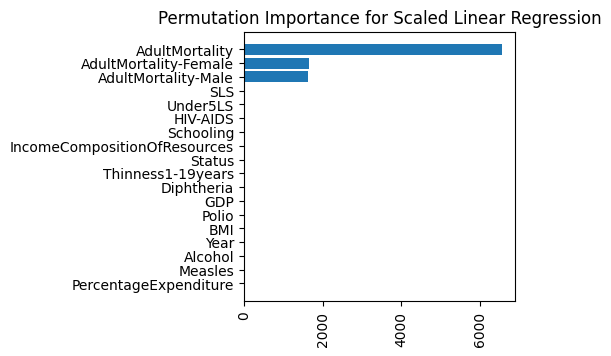

In [22]:
# Permutation Importance
from sklearn.inspection import permutation_importance

r = permutation_importance(model_lr, test_X_scaled, test_y, n_repeats=30)
inx = np.argsort(r.importances_mean)

plt.barh(test_X_scaled.columns[inx], r.importances_mean[inx])
plt.xticks(rotation='vertical')
plt.title("Permutation Importance for Scaled Linear Regression")
plt.rcParams['figure.figsize'] = [3.1, 3.1]
plt.show()

* After feature scaling and normalization, we observed a slight improvement in both R2 and Mean Squared Error.
* The permutation importance graph for the linear model after scaling and normalization shows that Adult Mortality, Adult Mortality-Male, and Adult Mortality-Female are the top three most important variables for predicting Life Expectancy. 
* This aligns with the hypothesis of a strong linear relationship that we identified during the EDA conducted previously. 
* We also can observe that other than those three most important variables, all other variables have only little or no impact on the target variable.

## Polynomial Regression Scaled

* Note that it is very important to scale the features when using Polynomial Regression. Therefore, we try to fit Polynomial Regression after Feature Scaling and Normalisation. 
* We will conduct hyperparameter tuning by fitting polynomial degrees ranging from 1 to 5 to select the model that achieves the lowest MSE.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

best_degree = float('inf')
lowest_mse = float('inf')

# hyper parameter tuning: fitting polynomial degrees ranging from 1 to 5(inclusive)
for i in range(1,6):
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(train_X_scaled)
    model_poly = LinearRegression().fit(X_poly, train_y)
    X_val_poly = poly.fit_transform(val_X_scaled)
    val_poly_pred = model_poly.predict(X_val_poly)

    r2_poly = r2_score(val_y, val_poly_pred)
    mse_poly = mean_squared_error(val_y, val_poly_pred)
    if mse_poly < lowest_mse: # Select the degree with the lowest Mean Squared Error (MSE)
        lowest_mse = mse_poly
        best_degree = i

# Fit the best degree model
print("The number of degree that has the lowest MSE is :", best_degree)
poly = PolynomialFeatures(best_degree)
X_poly = poly.fit_transform(train_X_scaled) # Transforming the predictors to polynomial
model_poly = LinearRegression().fit(X_poly, train_y)
X_test_poly = poly.fit_transform(test_X_scaled) # Transforming the predictors to polynomial
test_poly_pred = model_poly.predict(X_test_poly)

# Evaluation Method
r2_poly = r2_score(test_y, test_poly_pred)
mse_poly = mean_squared_error(test_y, test_poly_pred)
print("R^2 Score for scaled Polynomial Regression:", r2_poly)
print("Mean Squared Error for scaled Polynomial Regression:", mse_poly)

The number of degree that has the lowest MSE is : 2
R^2 Score for scaled Polynomial Regression: 0.7958918583792328
Mean Squared Error for scaled Polynomial Regression: 17.352022163510693


* R^2 and Mean Squared Error have significantly improved compared to unscaled Polynomial Distribution. 
* Therefore, we can conclude that a scaled 2nd degree Polynomial Distribution might be suitable for this dataset.

## Feature Removal (Multicollinearity)

* Based on EDA, we observed that multiple predictors are correlated to each other. 
* The Permutation Importance for the Scaled Linear Regression has shown that the top 3 important predictors are those predictors that are correlated to each other.
* We can remove the variables from the model to make it accurately estimate the individual effects of each predictor.

In [24]:
train_X_scaled = train_X_scaled.drop(['AdultMortality-Male',], axis=1)
test_X_scaled = test_X_scaled.drop(['AdultMortality-Male',], axis=1)
val_X_scaled = val_X_scaled.drop(['AdultMortality-Male',], axis=1)
train_X_scaled = train_X_scaled.drop(['AdultMortality-Female',], axis=1)
test_X_scaled = test_X_scaled.drop(['AdultMortality-Female',], axis=1)
val_X_scaled = val_X_scaled.drop(['AdultMortality-Female',], axis=1)

In [25]:
# Fit the best degree model
poly = PolynomialFeatures(best_degree)
X_poly = poly.fit_transform(train_X_scaled) # Transforming the predictors to polynomial
model_poly = LinearRegression().fit(X_poly, train_y)
X_test_poly = poly.fit_transform(test_X_scaled) # Transforming the predictors to polynomial
test_poly_pred = model_poly.predict(X_test_poly)

# Evaluation Method
r2_poly = r2_score(test_y, test_poly_pred)
mse_poly = mean_squared_error(test_y, test_poly_pred)
print("R^2 Score for scaled Polynomial Regression:", r2_poly)
print("Mean Squared Error for scaled Polynomial Regression:", mse_poly)

R^2 Score for scaled Polynomial Regression: 0.824077752559481
Mean Squared Error for scaled Polynomial Regression: 14.955830337793383


* From the evaluation scores above, we can see that the performance of the model has improved significantly.

## Regularisation

* Based on the EDA, we observed correlations among several predictor variables. 
* Applying regularization to the Polynomial Regression model might be appropriate to reduce overfitting and mitigate the effects of multicollinearity present in the data. This would help the model generalize well to unseen data. 
* We will apply L2 regularisation on the polynomial model to determine if the model is overfitting and evaluate its performance. 
* Additionally, we will perform parameter-tuning using validation set to determine the best lambda value for the Ridge model.

In [26]:
from sklearn.linear_model import Ridge

lambda_paras = np.logspace(-5, 1, num=25) # Define the parameters that you want to train
ridge_model = Ridge() # Fit a Ridge Model
poly = PolynomialFeatures(best_degree) # Use the best_degree that we found in the last section
train_X_poly = poly.fit_transform(train_X_scaled)
val_X_poly = poly.fit_transform(val_X_scaled)
train_performace = list()
valid_performace = list()
best_alpha = float('inf')
best_mse = float('inf')

for lambda_para in lambda_paras:
    
    ridge_model_best = Ridge(alpha=lambda_para).fit(train_X_poly, train_y) # Apply lambdas on the Ridge Regression
    
    y_val_pred = ridge_model_best.predict(val_X_poly) # Predict the validation set
    mse_val = mean_squared_error(val_y, y_val_pred)
    
    y_train_pred = ridge_model_best.predict(train_X_poly) # Predict the train set
    mse_train = mean_squared_error(train_y, y_train_pred)
    if mse_val < best_mse: # Select the model with the lowest MSE on the validation set
        best_mse = mse_val
        best_alpha = lambda_para
    
    train_performace.append(mse_train)
    valid_performace.append(mse_val)

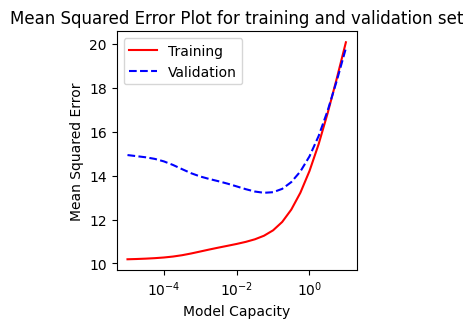

In [27]:
# Mean Squared Error Plot for training and validation set
plt.plot([lambda_para for lambda_para in lambda_paras], [tp for tp in train_performace], 'r-')
plt.plot([lambda_para for lambda_para in lambda_paras], [vp for vp in valid_performace], 'b--')
plt.xscale("log")
plt.title("Mean Squared Error Plot for training and validation set")
plt.ylabel('Mean Squared Error')
plt.xlabel('Model Capacity')
plt.legend(['Training', 'Validation'])
plt.rcParams['figure.figsize'] = [4, 4]
plt.show()

In [28]:
# Fitting Polynomial Ridge Regression with the best degree and best lambda
poly = PolynomialFeatures(best_degree)
train_X_poly = poly.fit_transform(train_X_scaled)

model_poly_ridge = Ridge(alpha=best_alpha).fit(train_X_poly, train_y) # Fit a model
X_test_poly = poly.fit_transform(test_X_scaled) # Transform predictors into polynomial
test_poly_pred = model_poly_ridge.predict(X_test_poly)
r2_poly = r2_score(test_y, test_poly_pred) # Transform predictors into polynomial
mse_poly = mean_squared_error(test_y, test_poly_pred)

print("R^2 Score for Polynomial Ridge Regression:", r2_poly)
print("Mean Squared Error for Polynomial Ridge Regression:", mse_poly)

R^2 Score for Polynomial Ridge Regression: 0.8434739524138859
Mean Squared Error for Polynomial Ridge Regression: 13.30688440604877


* Based on the Training vs Validation graph above, we found the best lamba value that generalise well on unseen data is 0.1. 
* We applied alpha=0.1 on Polynomial Ridge Regression to the training dataset and obtained the highest R^2 value and the lowest Mean Squared Error.

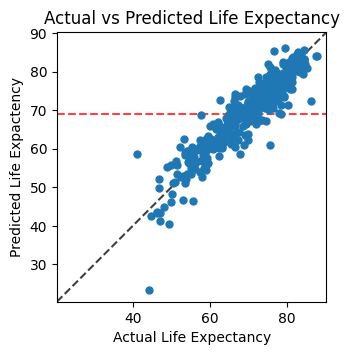

In [71]:
fig, ax = plt.subplots()
ax.scatter(test_y, test_poly_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(train_y),]*2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.title("Actual vs Predicted Life Expectancy")
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expactency')
plt.rcParams['figure.figsize'] = [2, 2]
plt.show()

In [30]:
print("The mean value of residuals: " + str(np.mean(test_y-test_poly_pred)))

The mean value of residuals: 0.09685799292249014


* In the Predicted vs Actual Life Expectancy graph for our final model, we observe that the data points closely follow the linear line. 
* The final Polynomial Ridge Regression is significantly better than our baseline model in terms of R^2 and Mean Squared Error. 
* The mean value of residuals is closer to 0 compared to our baseline model. Therefore, we will use this as the final model for predicting our test dataset.

## Conclusion

Our baseline model improves after:
* Removing Thinness5-9years, TotalExpenditure, Population and Country that are unimportant to the target variable.
* Applying feature scaling on all the attributes and normalisation on highly skewed attributes.
* Fitting a 2nd Degree Polynomial Regression, and it has the best R^2 and Mean Squared Error compared to linear regression.
* Dropping AdultMortality-Female and AdultMortality-Male to help mitigating multicollinearity issue.
* Applying Regularisation and Parameter tuning on 2nd Degree Polynomial Regression, with a lambda value of 0.1.

## Prediction

In [31]:
lifespan_pred = pd.read_csv('./test.csv')

In [32]:
# Dropping unimportant variables
lifespan_pred = lifespan_pred.drop(['ID',], axis=1)
lifespan_pred = lifespan_pred.drop(['Thinness5-9years',], axis=1)
lifespan_pred = lifespan_pred.drop(['TotalExpenditure',], axis=1)
lifespan_pred = lifespan_pred.drop(['Population',], axis=1)
lifespan_pred = lifespan_pred.drop(['Country',], axis=1)
lifespan_pred = lifespan_pred.drop(['Polio',], axis=1)

# Dropping correlated variables
lifespan_pred = lifespan_pred.drop(['AdultMortality-Female',], axis=1)
lifespan_pred = lifespan_pred.drop(['AdultMortality-Male',], axis=1)

In [33]:
# logNorm_attributes are list of attributes that are considered highly skewed that were defined during EDA
logNorm_attributes = ['Schooling','AdultMortality','Diphtheria','Thinness1-19years']
# All other attributes
minmax_attributes = list(set(lifespan_pred.columns).difference(set(logNorm_attributes)))

lifespan_pred_scaled = lifespan_pred.copy()

# Fitting Feature Scaling on all other attributes
minmaxscaler = MinMaxScaler().fit(lifespan_pred_scaled.loc[:, minmax_attributes])
lifespan_pred_scaled.loc[:, minmax_attributes] = minmaxscaler.transform(lifespan_pred_scaled.loc[:, minmax_attributes])

# Applying normalisation on highly skewed attributes
powertransformer = PowerTransformer(method='yeo-johnson', standardize=False).fit(lifespan_pred.loc[:, logNorm_attributes])
lifespan_pred_scaled.loc[:, logNorm_attributes] = powertransformer.transform(lifespan_pred.loc[:, logNorm_attributes])

# Fitting Feature Scaling on all the normalised attributes
minmaxscaler_pt = MinMaxScaler().fit(lifespan_pred_scaled.loc[:, logNorm_attributes])
lifespan_pred_scaled.loc[:, logNorm_attributes] = minmaxscaler_pt.transform(lifespan_pred_scaled.loc[:, logNorm_attributes])


In [34]:
# Fitting Polynomial Ridge Regression with the best degree and best lambda
poly = PolynomialFeatures(best_degree)
X_pred_poly = poly.fit_transform(lifespan_pred_scaled)
x_poly_pred = model_poly_ridge.predict(X_pred_poly)

In [35]:
# Load the solution
lifespan_pred_res = pd.read_csv('./sample_solution.csv')
lifespan_pred_res['TARGET_LifeExpectancy'] = x_poly_pred

<b>Head of the predicted values for our test data:</b>

In [36]:
lifespan_pred_res.head()

,ID,TARGET_LifeExpectancy
0,1,55.548993
1,2,53.821162
2,3,53.237861
3,4,52.361409
4,5,51.569372


In [37]:
lifespan_pred_res.to_csv('./predicted_life_expectancy.csv')